In [ ]:
""" import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
# Import necessary libraries

# Load the preprocessed EEG dataset
X = np.load('preprocessed_eeg.npy')
y = np.load('seizure_labels.npy')

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 71)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2) """


In [1]:
import glob
import json
import os
import random
import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics
import sklearn.preprocessing

from tensorflow import keras

2023-11-09 15:06:54.094327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# data summary: 
# chb01: 46 files, seizures at 3, 4, 15, 16, 18, 21, 26
# chb02: 35 files, seizures at 16, 19
# chb03: 38 files, seizures at 1, 2, 3, 4, 34, 35, 36
# chb04: 43 files, seizures at 5, 8, 28
# chb05: 39 files, seizures at 6, 13, 16, 17, 22

# sampling rate (in Hz)
s_rate = 256 

# Length (in seconds) of extraction window
w_size = 50

# indices of files that contain seizures
s_loc = [
    [3, 4, 15, 16, 18, 21, 26],
    [16, 19],
    [1, 2, 3, 4, 34, 35, 36],
    [5, 8, 28],
    [6, 13, 16, 17, 22]
]

# lower bounds of seizures
s_begin = [
    [2996, 1467, 1732, 1015, 1720, 327, 1862],
    [130, 3369],
    [362, 731, 432, 2162, 1982, 2592, 1725],
    [7804, 6446, 1679],
    [417, 1086, 2317, 2451, 2348]
]

# upper bounds of seizures (original, not used)
# s_end = [
#     [3036, 1494, 1772, 1066, 1810, 420, 1963],
#     [212, 3378],
#     [414, 796, 501, 2214, 2029, 2656, 1778],
#     [7853, 6557, 1781],
#     [532, 1196, 2413, 2571, 2465]
# ]

# initialize output dataframe
df_extracted = pd.DataFrame()

# process edf data from each patient directory
s_i = 0

for i in range(len(s_loc)):
    # get directory path
    file_path = 'data/chb%02d' % (i + 1)
    
    # read all edf files in directory
    edf_files = glob.glob(os.path.join(file_path, '*.edf'))
    
    for filename in edf_files:
        print('Reading %s, s_i=%d' % (filename, s_i))

        # read edf file
        edf = mne.io.read_raw_edf(filename, verbose=False)

        # create dataframe from edf data
        df_raw = pd.DataFrame(data=edf.get_data().T, columns=edf.ch_names)

        # extract index from filename
        j = int(filename.replace('.', '_').split('_')[-2])

        # extract seizure data if it is present
        if j in s_loc[i]:
            s_idx = s_loc[i].index(j)
            begin = s_begin[i][s_idx]

        # otherwise extract from the beginning
        else:
            begin = 0

        # read each channel into dataframe
        for channel in df_raw.columns:
            # insert_data.reset_index(drop=True, inplace=True)
            df_extracted['%s_%d' % (channel, s_i)] = df_raw.loc[begin * s_rate : (begin + w_size) * s_rate - 1, channel]

        # rename weird column name
        df_extracted.rename(columns={ '# FP1-F7_%d' % (s_i) : 'FP1-F7_%d' % (s_i) }, inplace=True)

        # increment global index
        s_i += 1

# save extracted data to csv file
df_extracted.to_csv('seizure.csv', index=False, float_format='%.8g')

Reading data/chb01/chb01_42.edf, s_i=0
Reading data/chb01/chb01_43.edf, s_i=1
Reading data/chb01/chb01_41.edf, s_i=2
Reading data/chb01/chb01_40.edf, s_i=3
Reading data/chb01/chb01_46.edf, s_i=4
Reading data/chb01/chb01_09.edf, s_i=5
Reading data/chb01/chb01_21.edf, s_i=6
Reading data/chb01/chb01_20.edf, s_i=7
Reading data/chb01/chb01_34.edf, s_i=8
Reading data/chb01/chb01_08.edf, s_i=9
Reading data/chb01/chb01_22.edf, s_i=10
Reading data/chb01/chb01_36.edf, s_i=11
Reading data/chb01/chb01_37.edf, s_i=12
Reading data/chb01/chb01_23.edf, s_i=13
Reading data/chb01/chb01_27.edf, s_i=14
Reading data/chb01/chb01_33.edf, s_i=15
Reading data/chb01/chb01_32.edf, s_i=16
Reading data/chb01/chb01_26.edf, s_i=17
Reading data/chb01/chb01_30.edf, s_i=18
Reading data/chb01/chb01_24.edf, s_i=19
Reading data/chb01/chb01_18.edf, s_i=20
Reading data/chb01/chb01_19.edf, s_i=21
Reading data/chb01/chb01_25.edf, s_i=22
Reading data/chb01/chb01_31.edf, s_i=23
Reading data/chb01/chb01_14.edf, s_i=24
Reading da

In [6]:
# extract channel names from extracted dataframe
channels = [c.split('_')[0] for c in df_extracted.columns]
channels = list(set(channels))

# save separate csv files for each channel
for channel in channels:
    print(channel)

    # extract columns that belong to channel
    columns = [name for name in df_extracted.columns if name.startswith(channel)]

    # create dataframe for channel
    df_channel = df_extracted[columns]
    df_channel.columns = [c.split('_')[1] for c in df_channel.columns]

    # save dataframe to csv file
    df_channel.to_csv('seizure.%s.csv' % (channel), index=False, float_format='%.8g')

CZ-PZ
T8-P8-1
F4-C4
P3-O1
F3-C3
C3-P3
P8-O2
P7-T7
C4-P4
FP2-F8
FT9-FT10
FP1-F3
T8-P8-0
FT10-T8
FZ-CZ
F7-T7
FP1-F7
ECG
P4-O2
F8-T8
FP2-F4
T7-FT9
P7-O1
T7-P7


## CNN Seizure Classifier

In [7]:
def train_test_split(X, y, train_size=0.8, n_timesteps=12800):
    # compute split index
    split_index = int(X.shape[0] * train_size)

    # extract train set
    X_train = X[:split_index, :n_timesteps]
    y_train = y[:split_index]

    # extract test set
    X_test = X[split_index:, :n_timesteps]
    y_test = y[split_index:]

    return X_train, y_train, X_test, y_test

def create_cnn(X_train, y_train, X_test, y_test):
    # get data dimensions
    n_timesteps = X_train.shape[1]
    n_channels = X_train.shape[2]

    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(n_timesteps, n_channels)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def run_experiment():
    # create train/test data
    X_train, y_train, X_test, y_test = train_test_split(X, y)

    # create model
    model = create_cnn(X_train, y_train, X_test, y_test)

    # print model summary
    model.summary()

    # train model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=True)

    # evaluate model
    score = model.evaluate(X_test, y_test)

    # print test accuracy for test set
    print('test accuracy: %f' % (score[1]))
    
    # plot the training accuracy
    plt.figure(figsize=(20, 6))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    # plot the training loss
    plt.figure(figsize=(20, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

In [11]:
#note: remove file 'seizure.ECG.csv' as it is not used and will cause an error
#!rm -f seizure.ECG.csv

# load csv files for each channel
csv_files = glob.glob('seizure.*.csv')
channels = []

for filename in csv_files:
    print(filename)

    channel = pd.read_csv(filename)
    channel = channel.values.T
    channels.append(channel)

# stack channels into 3-d numpy array
X = np.dstack(channels)

# print data dimensions (n_samples x n_timesteps x n_channels)
print(X.shape)

seizure.F4-C4.csv
seizure.FT9-FT10.csv
seizure.P7-T7.csv
seizure.FT10-T8.csv
seizure.CZ-PZ.csv
seizure.F8-T8.csv
seizure.C3-P3.csv
seizure.P4-O2.csv
seizure.P8-O2.csv
seizure.FP2-F4.csv
seizure.T7-P7.csv
seizure.F7-T7.csv
seizure.FP2-F8.csv
seizure.FZ-CZ.csv
seizure.T8-P8-0.csv
seizure.C4-P4.csv
seizure.T8-P8-1.csv
seizure.T7-FT9.csv
seizure.P3-O1.csv
seizure.FP1-F7.csv
seizure.P7-O1.csv
seizure.F3-C3.csv
seizure.FP1-F3.csv
(196, 12800, 23)


In [13]:
# indices of files that contain seizures
s_loc = [
    [3, 4, 15, 16, 18, 21, 26],
    [16, 19],
    [1, 2, 3, 4, 34, 35, 36],
    [5, 8, 28],
    [6, 13, 16, 17, 22]
]

# compute labels from indices
y = []

for i in range(len(s_loc)):
    # get directory path
    file_path = 'data/chb%02d' % (i + 1)

    # read all edf files in directory
    edf_files = glob.glob(os.path.join(file_path, '*.edf'))
    
    for filename in edf_files:
        # extract index from filename
        j = int(filename.replace('.', '_').split('_')[-2])

        # label positive example (seizure)
        if j in s_loc[i]:
            y.append(1)

        # label negative example (no seizure)
        else:
            y.append(0)

# print label stats                
print("Number of positive examples: %d" % (y.count(1)))
print("Number of negative examples: %d" % (y.count(0)))

# convert labels to numpy array
y = np.array(y)

Number of positive examples: 24
Number of negative examples: 172


In [14]:
run_experiment()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12800, 64)         4480      
                                                                 
 conv1d_1 (Conv1D)           (None, 12800, 64)         12352     
                                                                 
 dropout (Dropout)           (None, 12800, 64)         0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 6400, 64)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 409600)            0         
                                                                 
 dense (Dense)               (None, 100)               40960100  
                                                        

KeyError: 'acc'

<Figure size 2000x600 with 0 Axes>

## LSTM TIME Series Forecasting

In [16]:
def lstm_create(window_size):
    # create lstm model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(window_size, return_sequences=True, input_shape=(window_size, 1)))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.LSTM(256))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1))
    model.add(keras.layers.Activation("linear"))

    # compile model
    model.compile(loss="mse", optimizer="adam")

    return model

def lstm_train(model, X_train, y_train):
    t1 = time.time()
    model.fit(X_train, y_train, batch_size=512, epochs=3, validation_split=0.1, verbose=False)
    t2 = time.time()

    print('train time: %f s' % (t2 - t1))

def lstm_predict(model, X_test, y_test, scaler, n_steps):
    # compute single-step prediction
    if n_steps == 1:
        y_pred = model.predict(X_test)

    # or compute multi-step prediction (note: does not work yet)
    else:
        y_pred = np.empty(n_steps)
        X_window = X_test[0:1, :]

        for i in range(n_steps):
            # compute single-step prediction
            y_pred_i = model.predict(X_window)
            y_pred_i = y_pred_i.reshape(1, 1, 1)

            # append single-step prediction to multi-step prediction
            y_pred[i] = y_pred_i[0, 0, 0]

            # update moving window
            X_window = np.concatenate([X_window[:, 1:, :], y_pred_i], axis=1)

    # get de-normalized ground truth, model predictions
    y_test = scaler.inverse_transform(y_test)
    y_pred = scaler.inverse_transform(y_pred)

    # report mean-squared error
    print('mse: %g' % (sklearn.metrics.mean_squared_error(y_test, y_pred)))

    return y_pred, y_test

def lstm_forecast(x, window_size=100, train_size=0.8, n_steps=1):
    # normalize input data to the range [-1, 1]
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x)

    # augment input data with time-shifted copies
    x_orig = x.copy()

    for i in range(window_size):
        x = pd.concat([x, x_orig.shift(-(i+1))], axis=1)

    # remove rows with missing data
    x.dropna(axis=0, inplace=True)

    # convert input data to numpy array
    x = x.values
    x = x.reshape(x.shape[0], x.shape[1], 1)

    # create train/test sets
    split_index = int(x.shape[0] * train_size)

    train = x[:split_index, :]
    test = x[split_index:, :]

    train = sklearn.utils.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    # create lstm model
    model = lstm_create(window_size)

    # print model summary
    # model.summary()

    # train lstm model
    lstm_train(model, X_train, y_train)

    # compute forecast
    y_pred, y_test = lstm_predict(model, X_test, y_test, scaler, n_steps)

    return y_pred, y_test

def lstm_plot(y_test, y_pred, channel_name):
    s_rate = 256
    t = np.arange(len(y_test)) / s_rate

    plt.figure(figsize=(20, 6))
    plt.plot(t, y_test, label='Actual')
    plt.plot(t, y_pred, label='Predicted')
    plt.legend()
    plt.xlabel('Time (t) [s]')
    plt.ylabel('Voltage (V) [V]')
    plt.title('EEG Forecast for %s' % (channel_name))
    plt.show()

In [17]:
# get channel csv filenames
csv_files = glob.glob('seizure.*.csv')

# initialize output arrays
channels = []
y_pred = []
y_test = []

# perform time series forecast for each channel
for filename in csv_files:
    # get channel name
    channel_name = filename.split('.')[-2]

    print(channel_name)

    # read channel dataframe
    df_channel = pd.read_csv(filename)

    # perform forecasting for a random sample
    column = random.choice(df_channel.columns)

    # extract channel k, sample i
    x_ki = pd.DataFrame(df_channel[column])

    # perform time series forecasting
    y_pred_ki, y_test_ki = lstm_forecast(x_ki)

    # append results
    channels.append(channel_name)
    y_pred.append(y_pred_ki)
    y_test.append(y_test_ki)

F4-C4
train time: 91.635163 s
80/80 [==============================] - 6s 63ms/step
mse: 8.81886e-11
FT9-FT10
train time: 84.076786 s
80/80 [==============================] - 6s 64ms/step
mse: 1.76412e-10
P7-T7
train time: 106.331638 s
80/80 [==============================] - 7s 63ms/step
mse: 2.87804e-11
FT10-T8
train time: 94.680321 s
80/80 [==============================] - 7s 73ms/step
mse: 7.18363e-11
CZ-PZ
train time: 91.945947 s
80/80 [==============================] - 7s 58ms/step
mse: 4.00686e-11
F8-T8
train time: 87.477745 s
80/80 [==============================] - 7s 66ms/step
mse: 1.0407e-10
C3-P3
train time: 87.797756 s
80/80 [==============================] - 6s 61ms/step
mse: 2.85621e-10
P4-O2
train time: 83.116931 s
80/80 [==============================] - 6s 60ms/step
mse: 6.02499e-11
P8-O2
train time: 82.823274 s
80/80 [==============================] - 6s 61ms/step
mse: 4.15397e-10
FP2-F4
train time: 82.978533 s
80/80 [==============================] - 6s 61ms/step
m

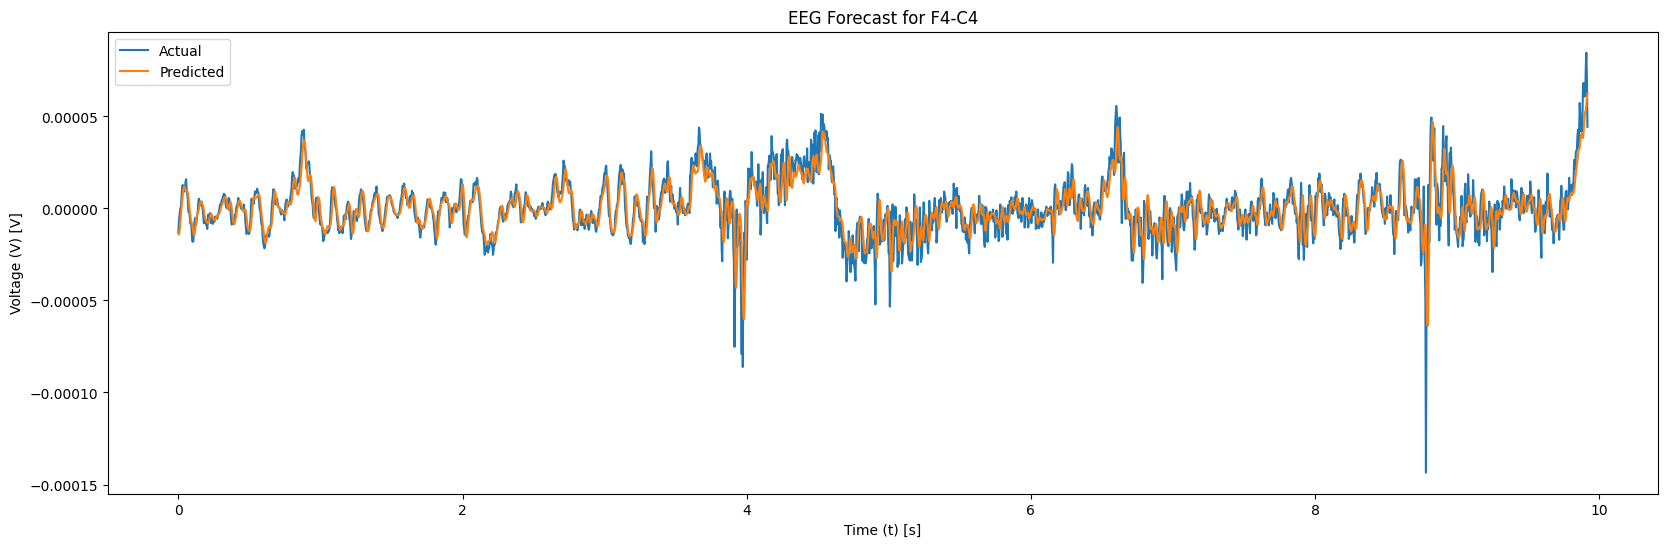

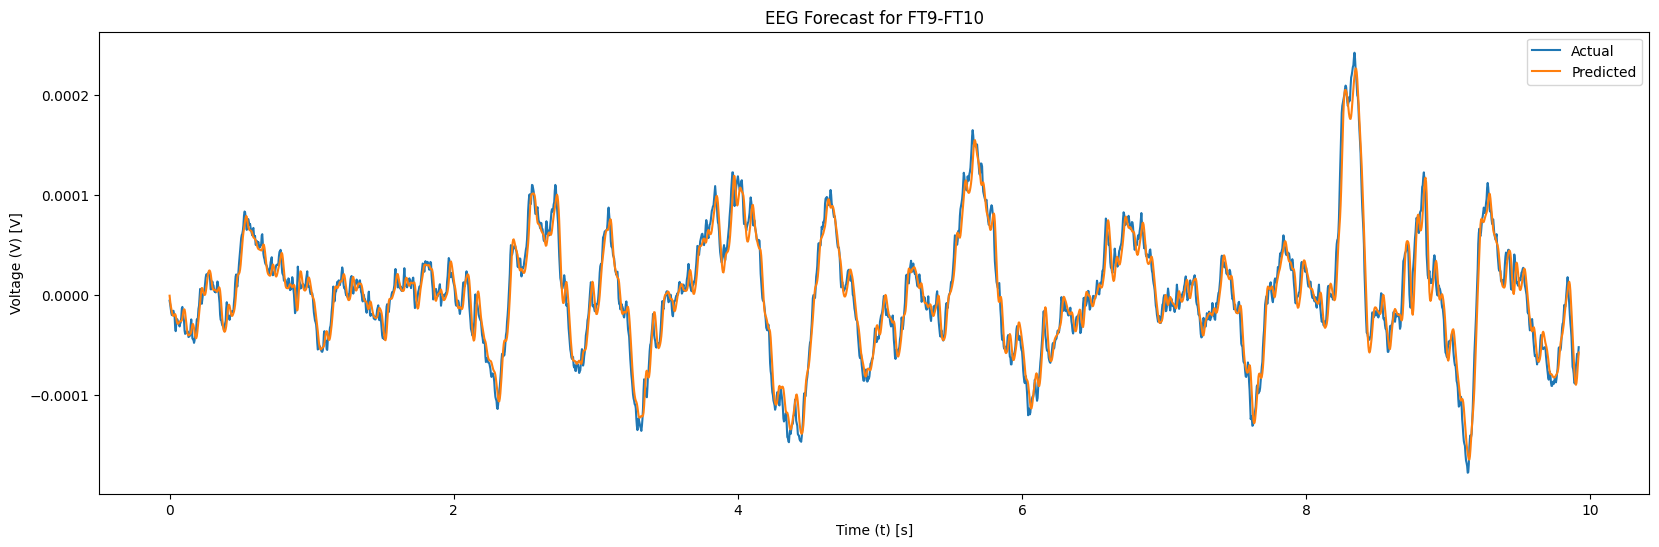

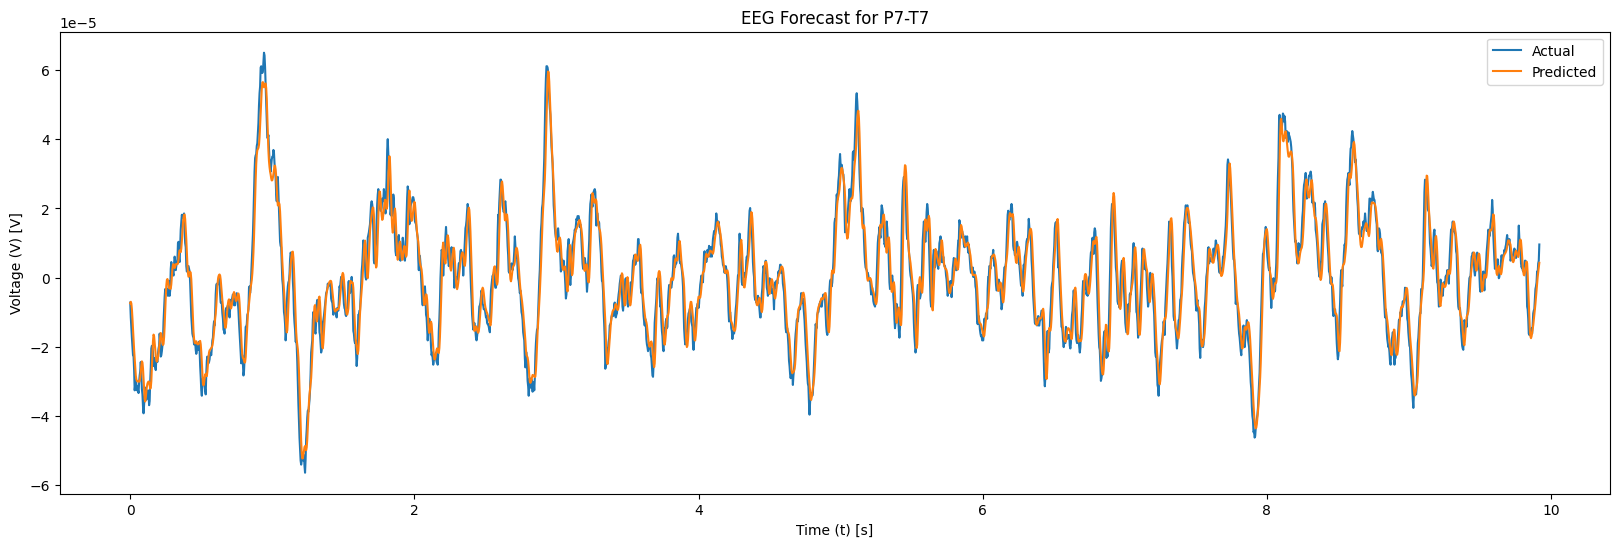

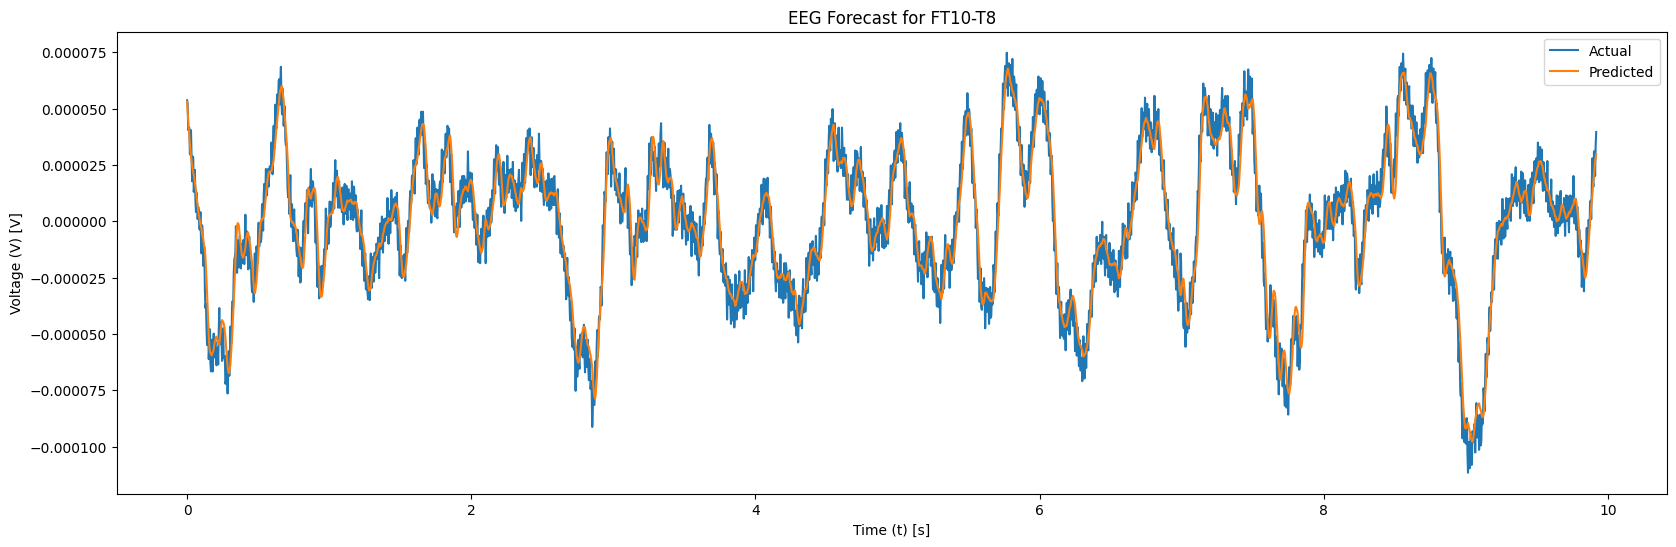

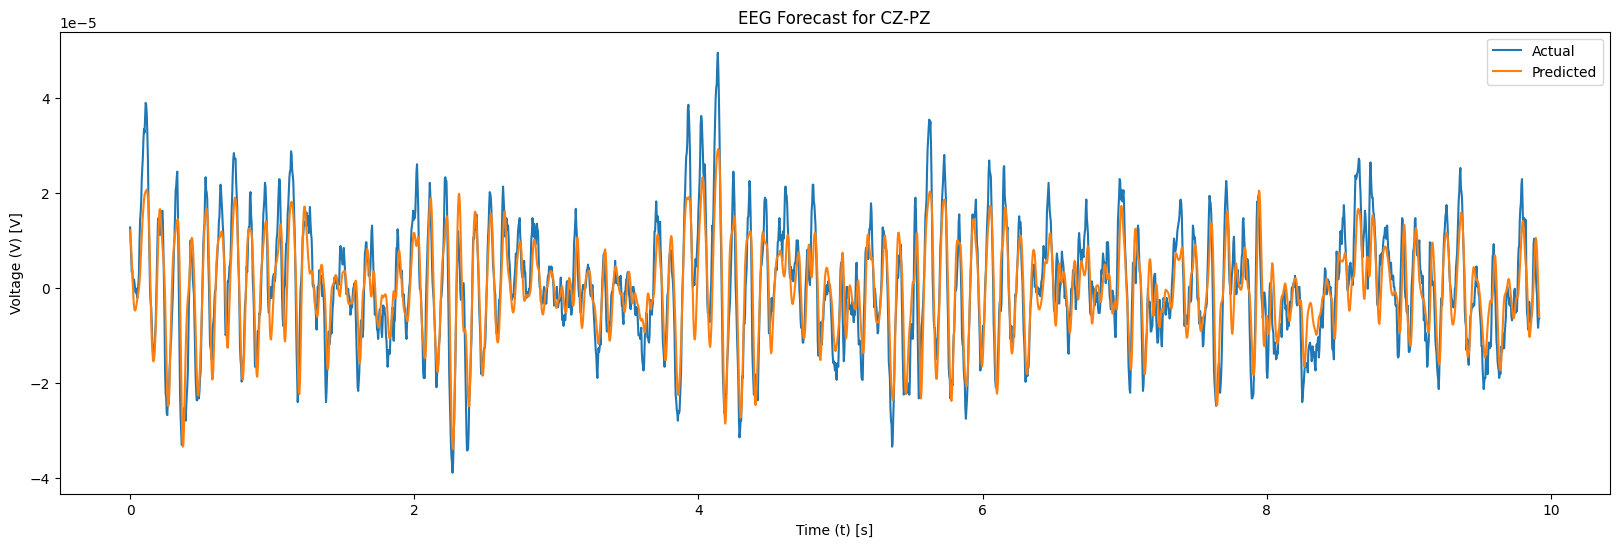

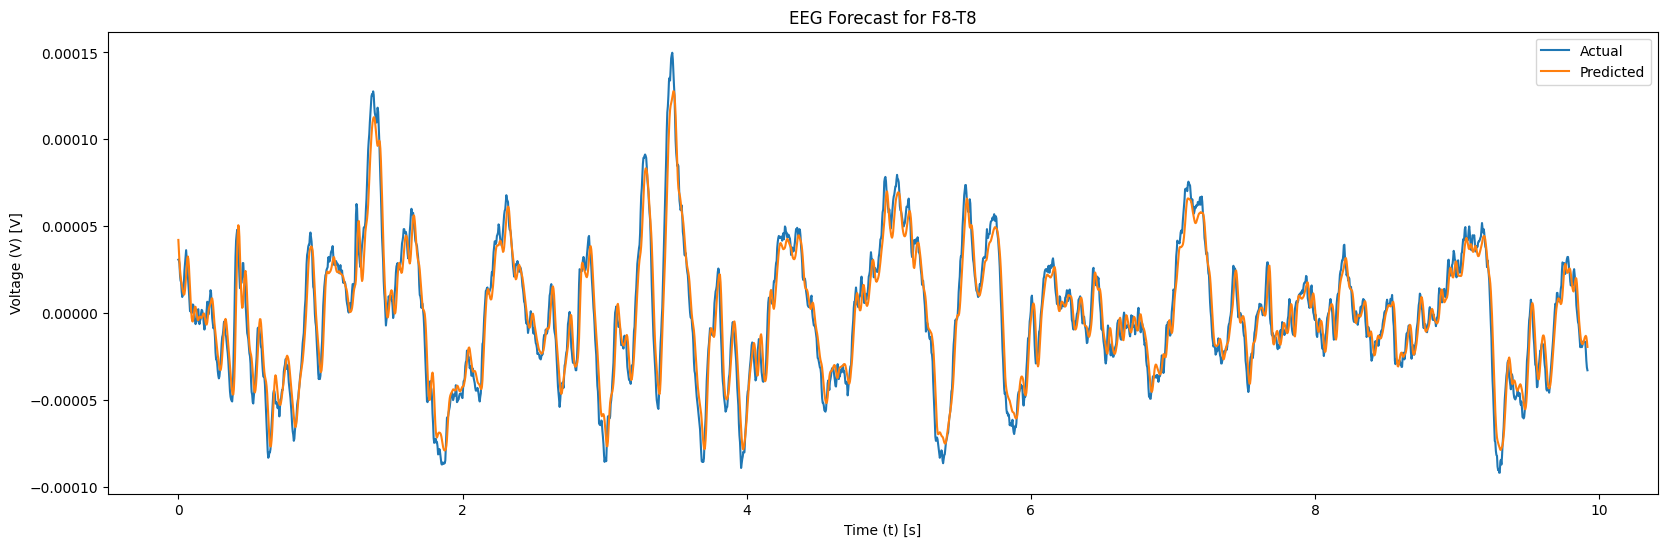

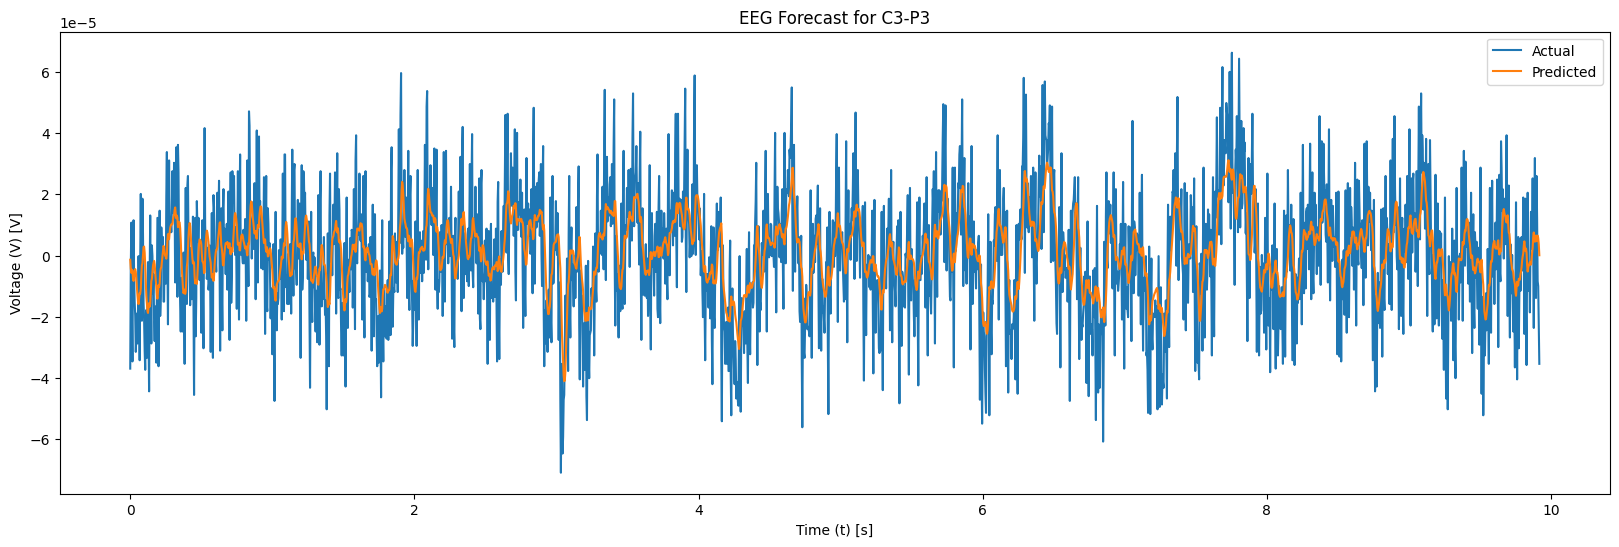

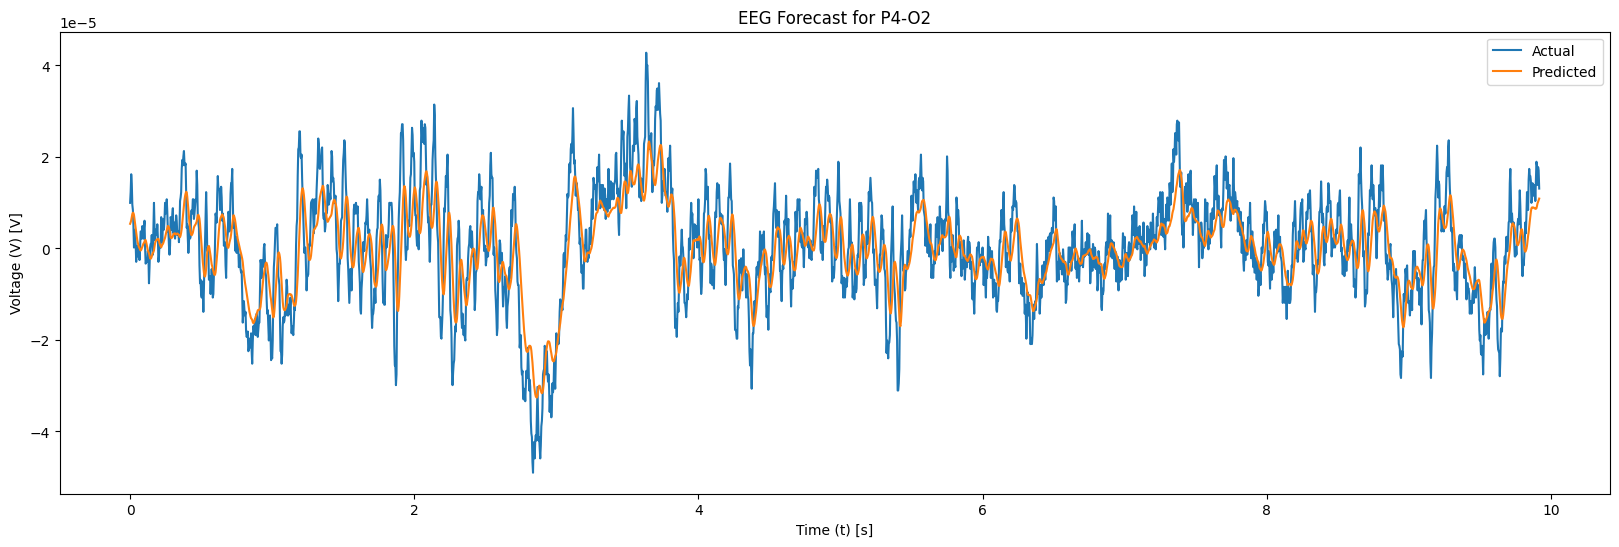

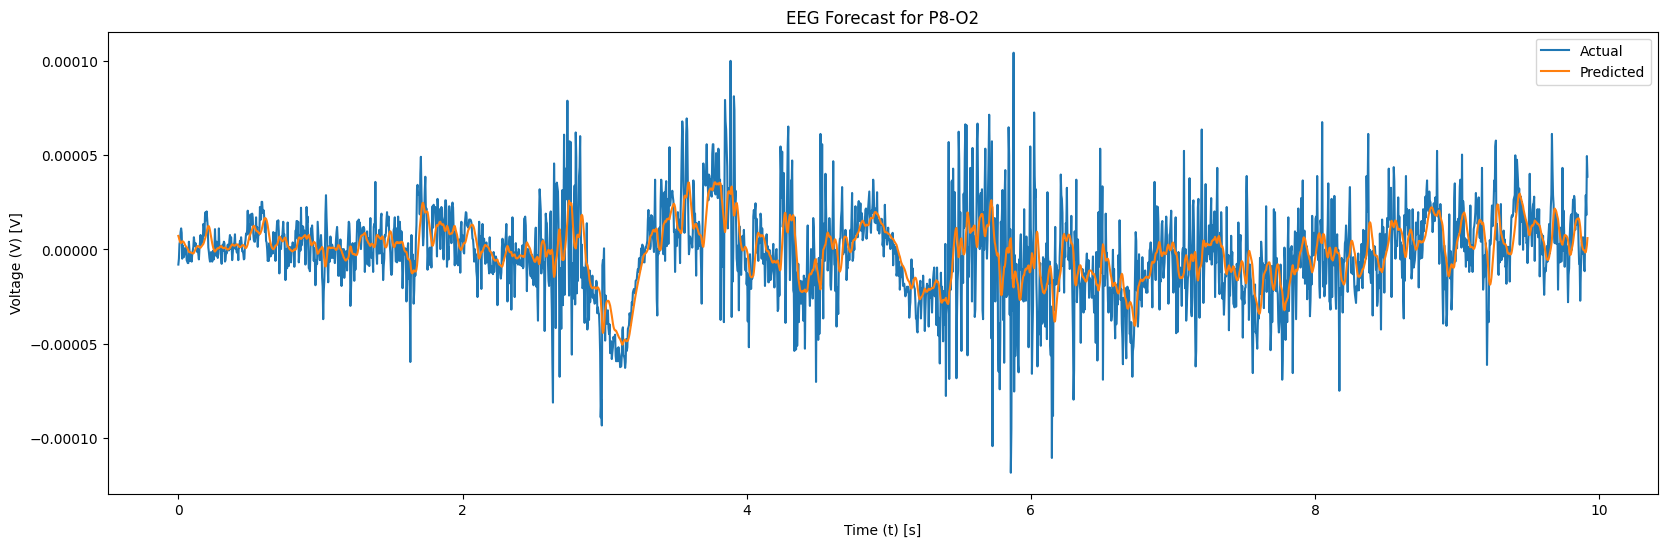

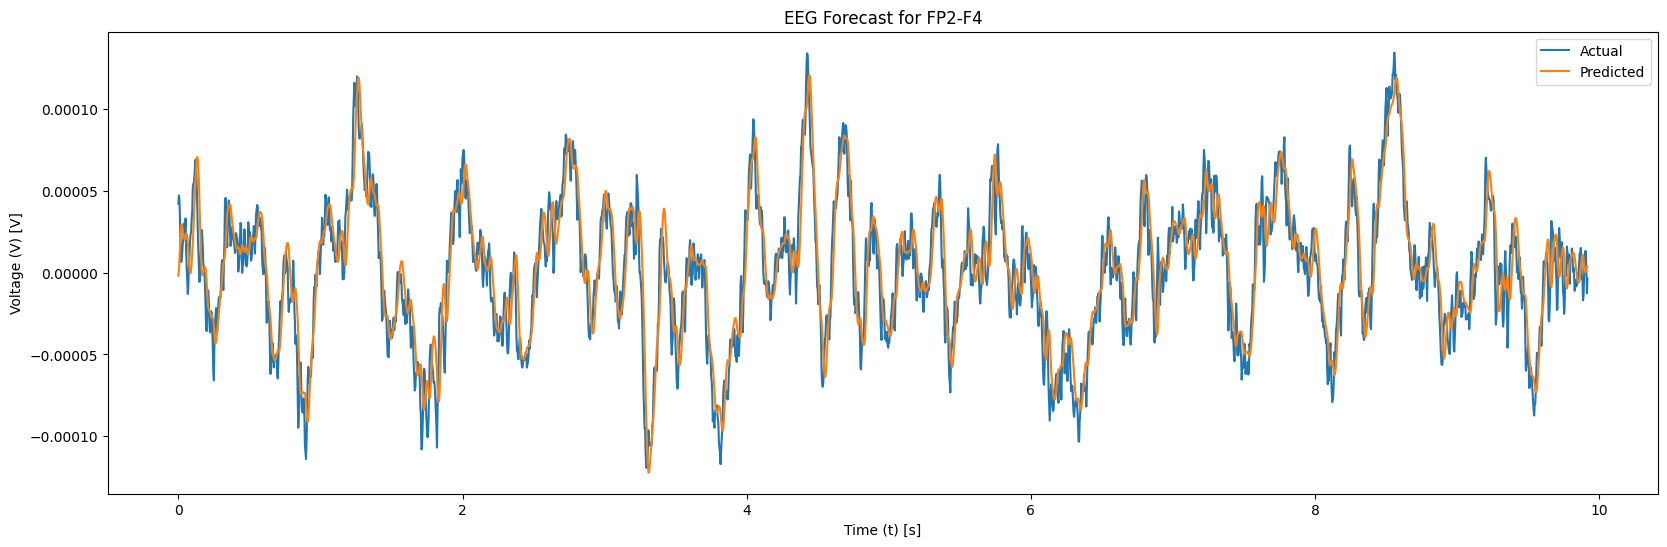

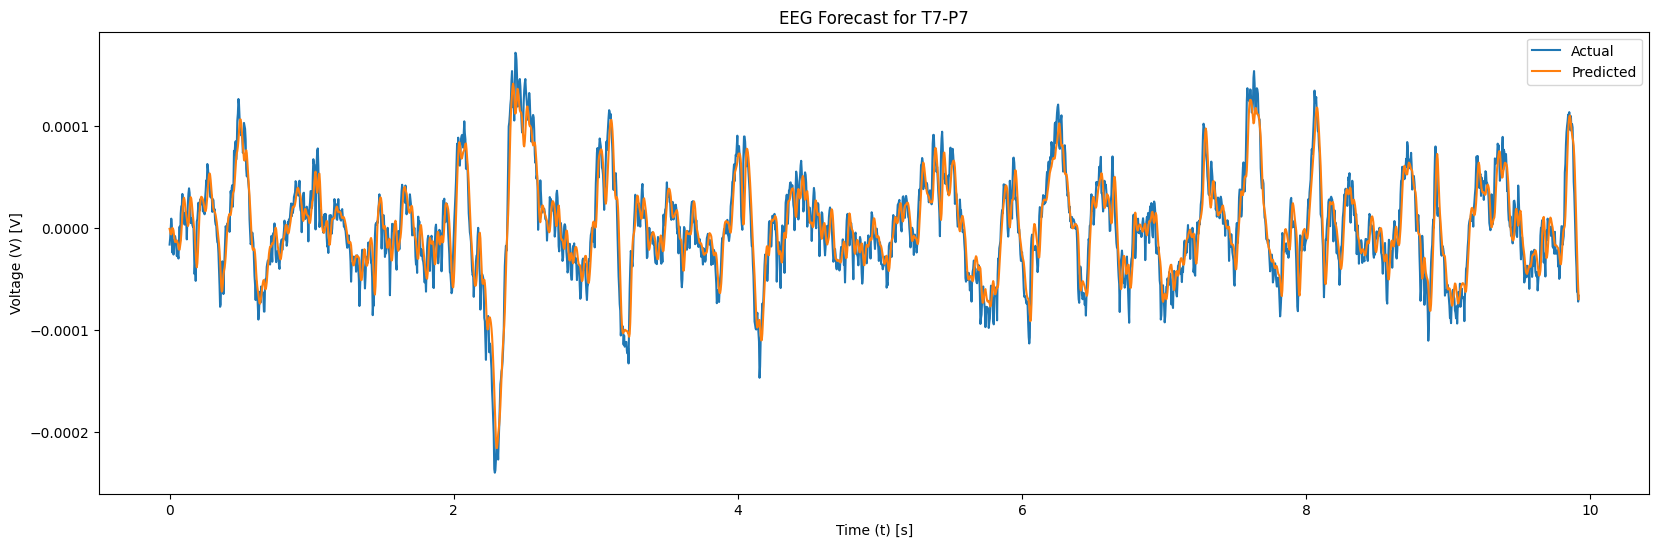

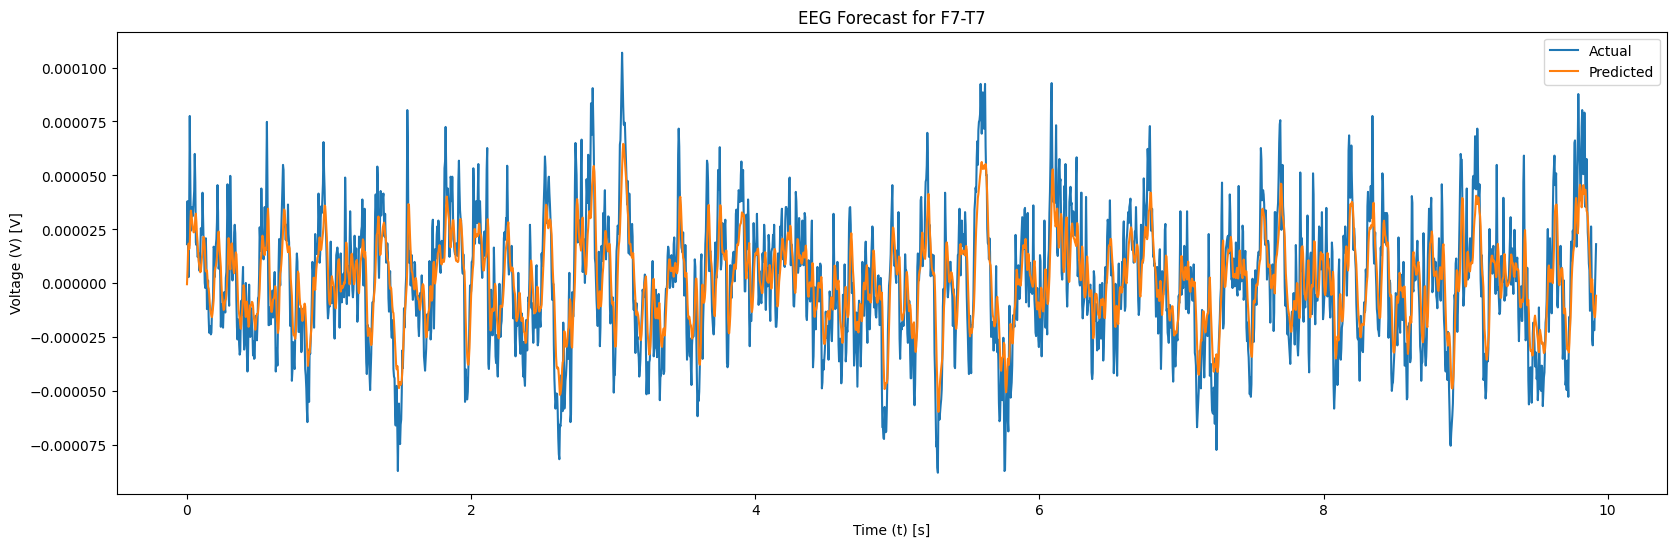

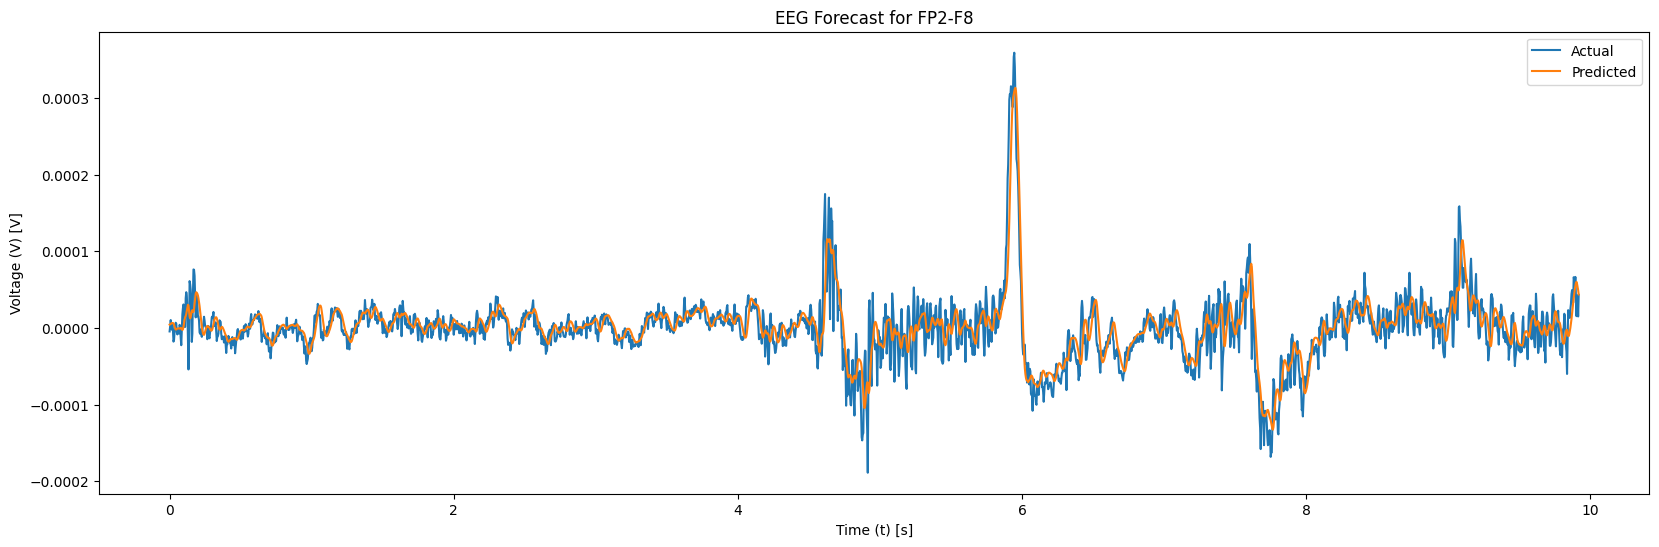

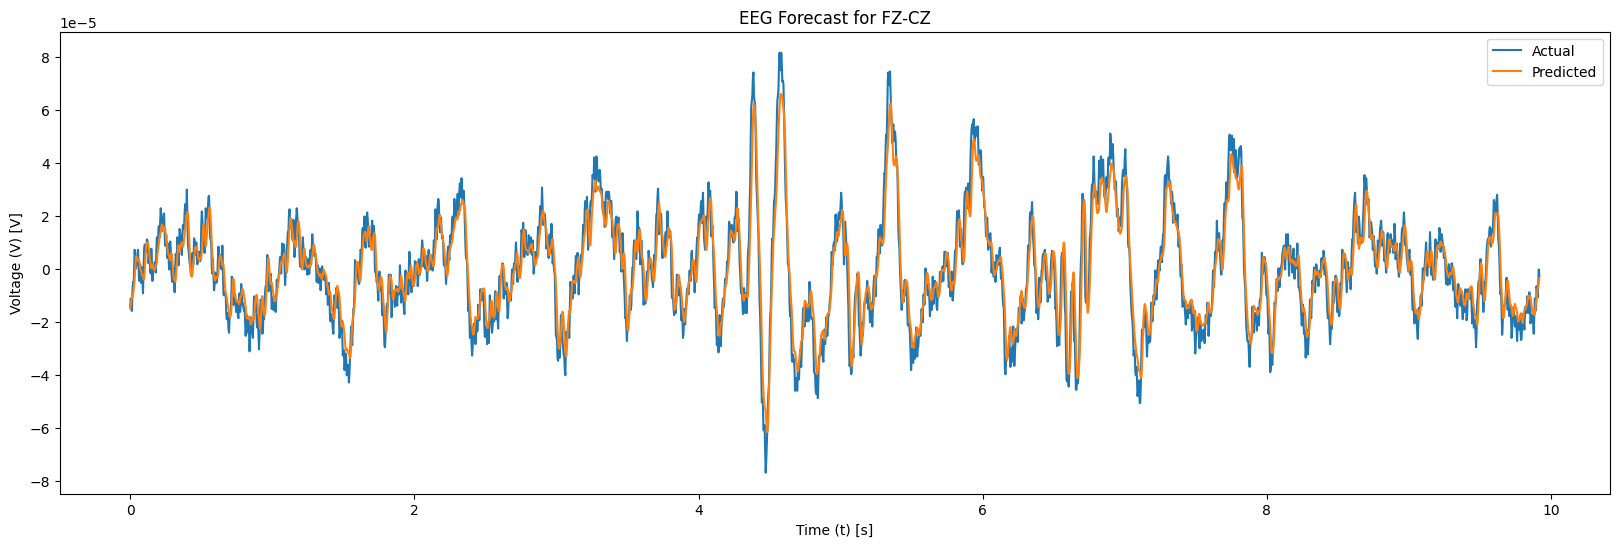

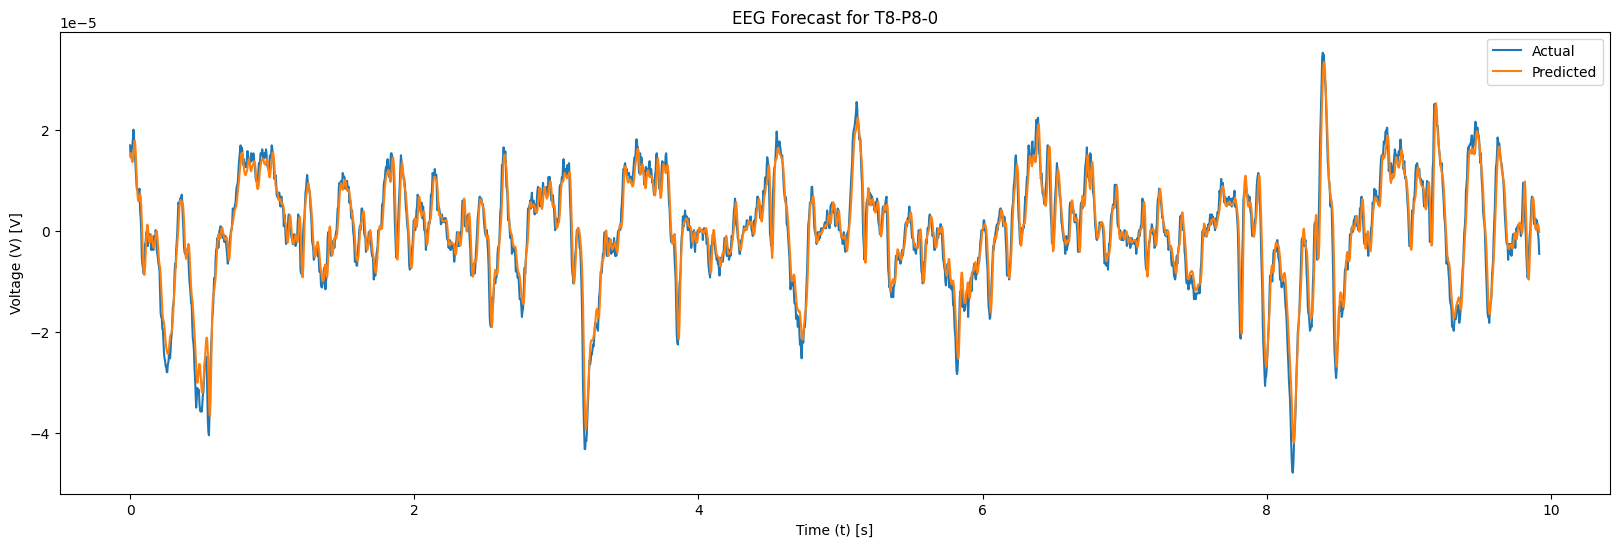

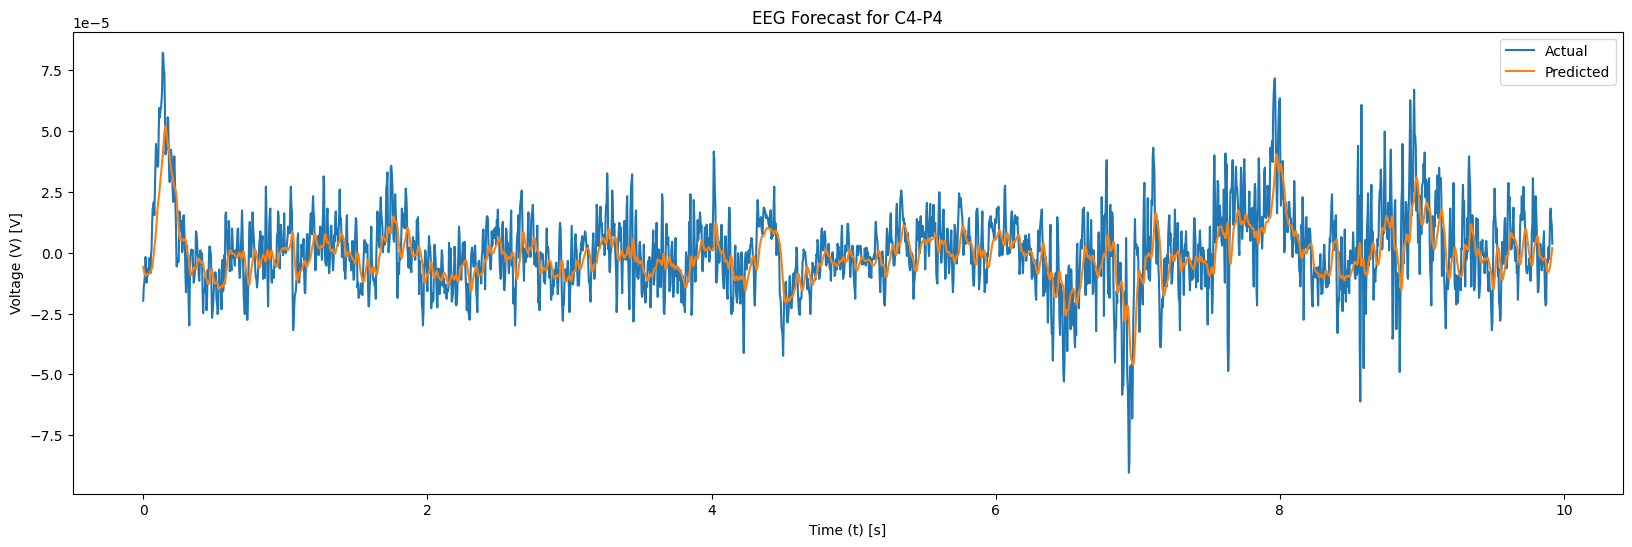

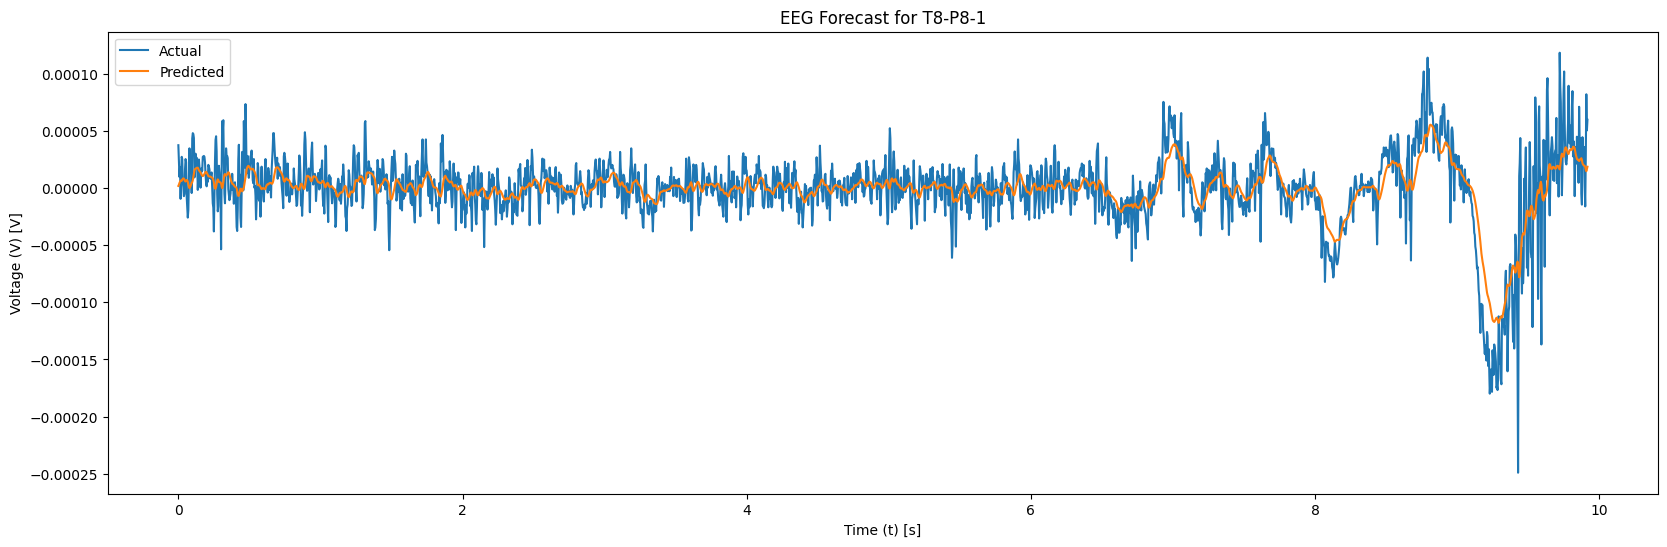

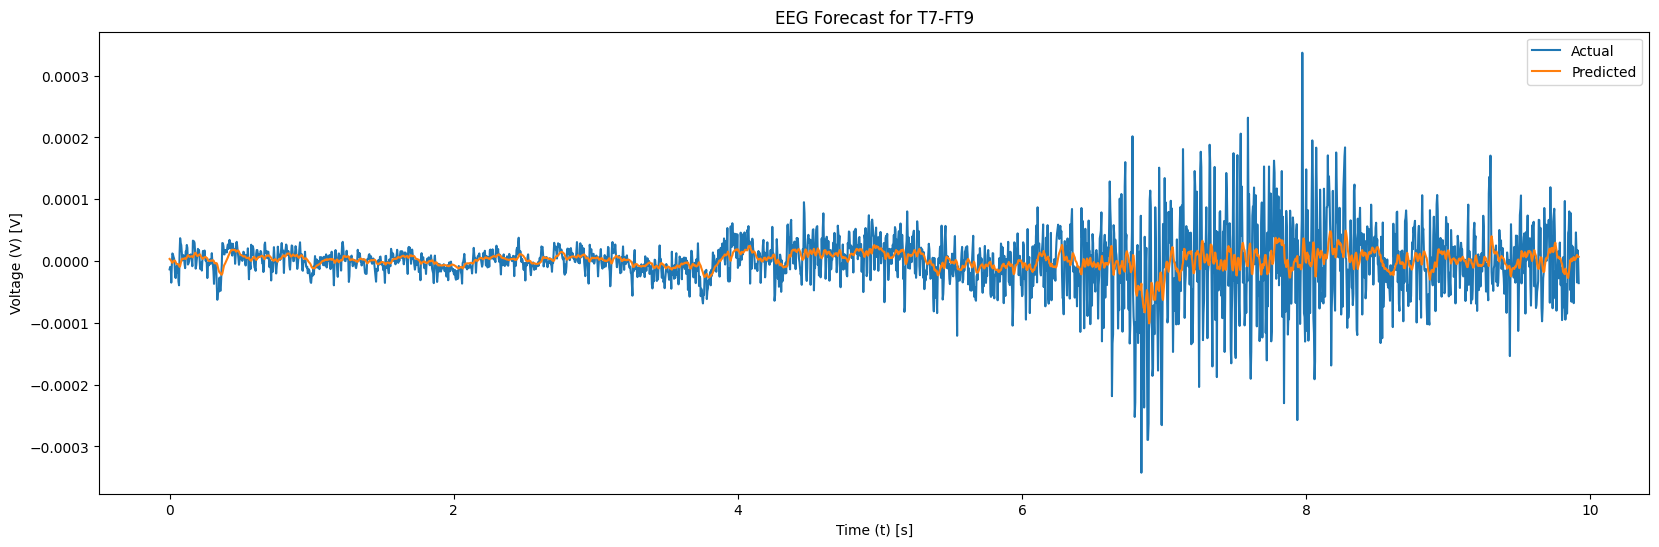

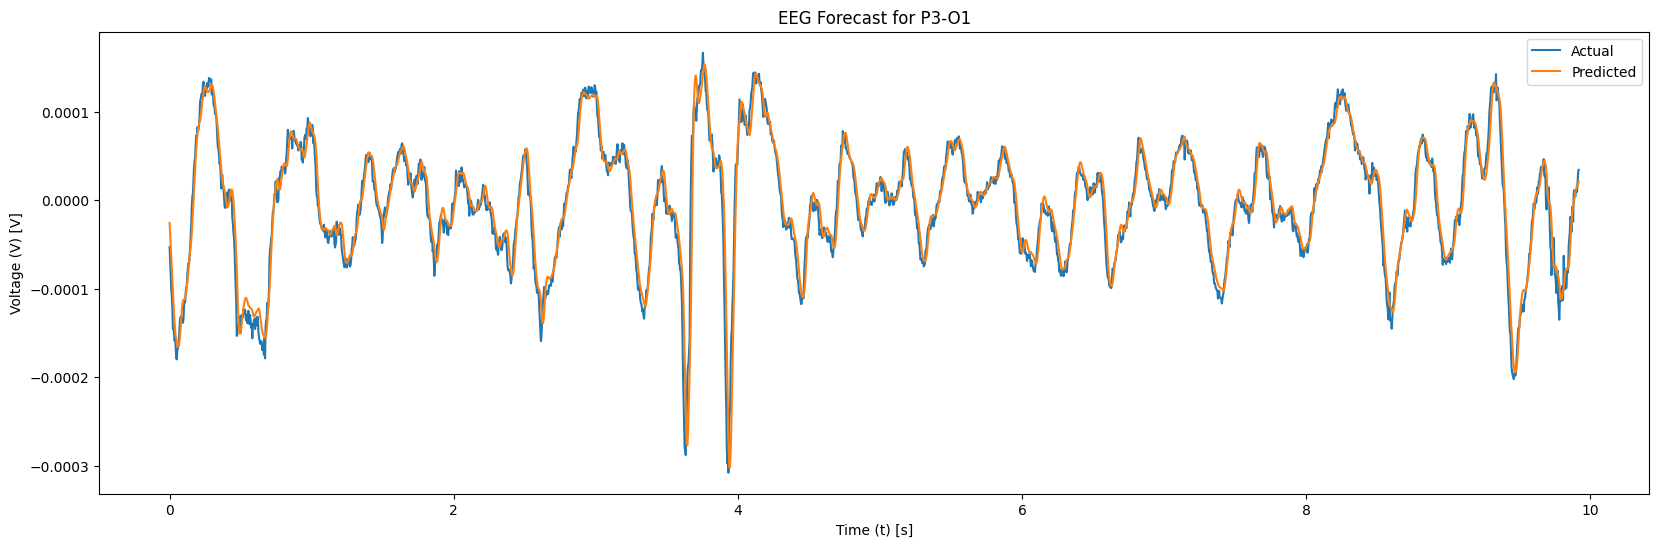

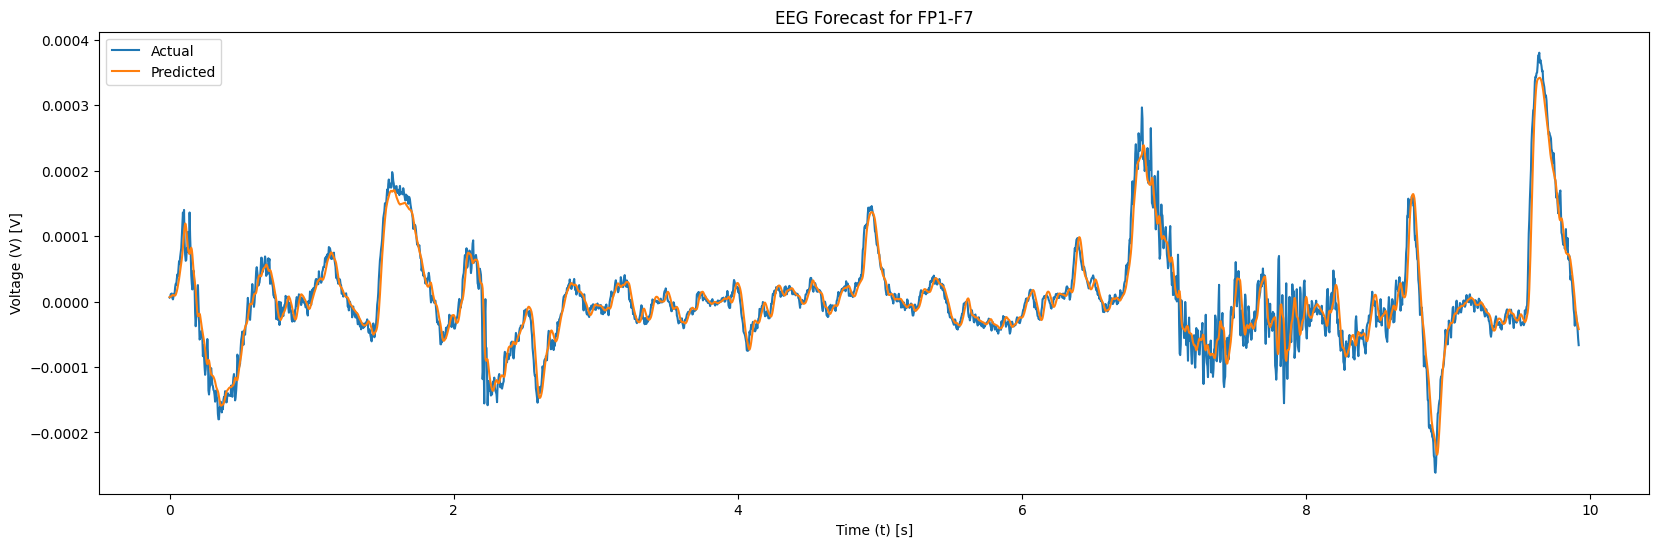

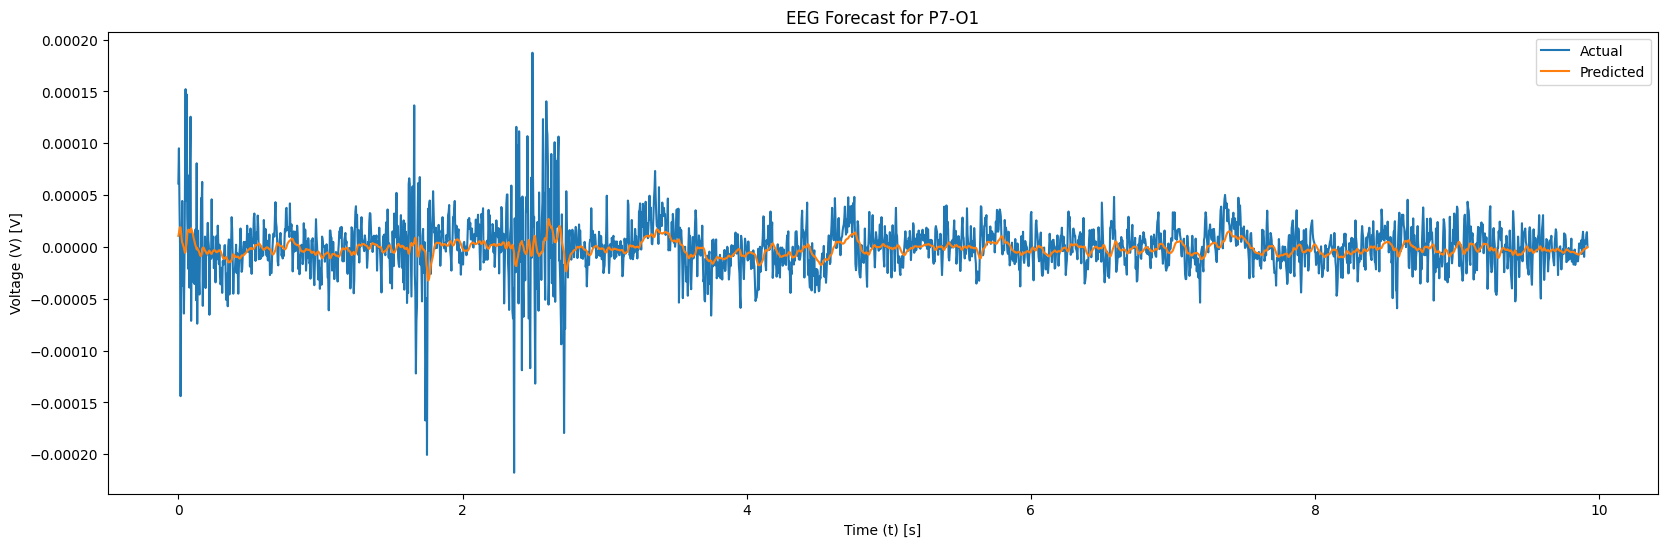

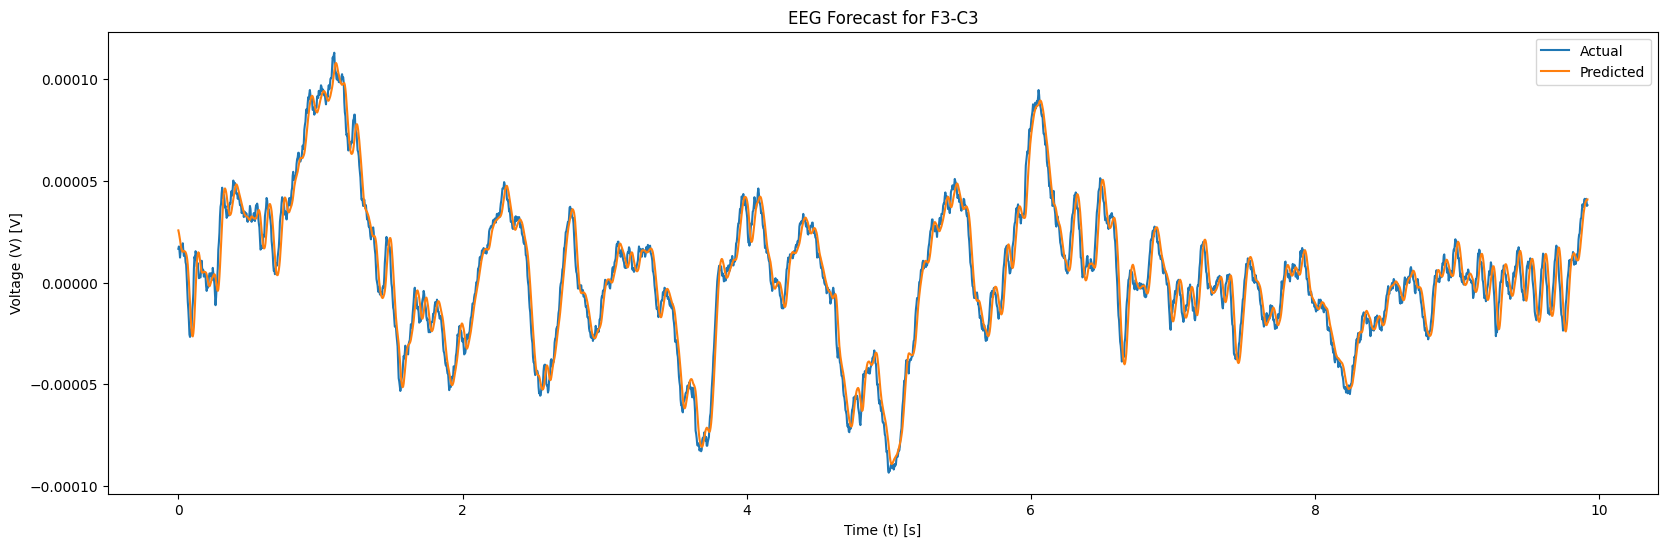

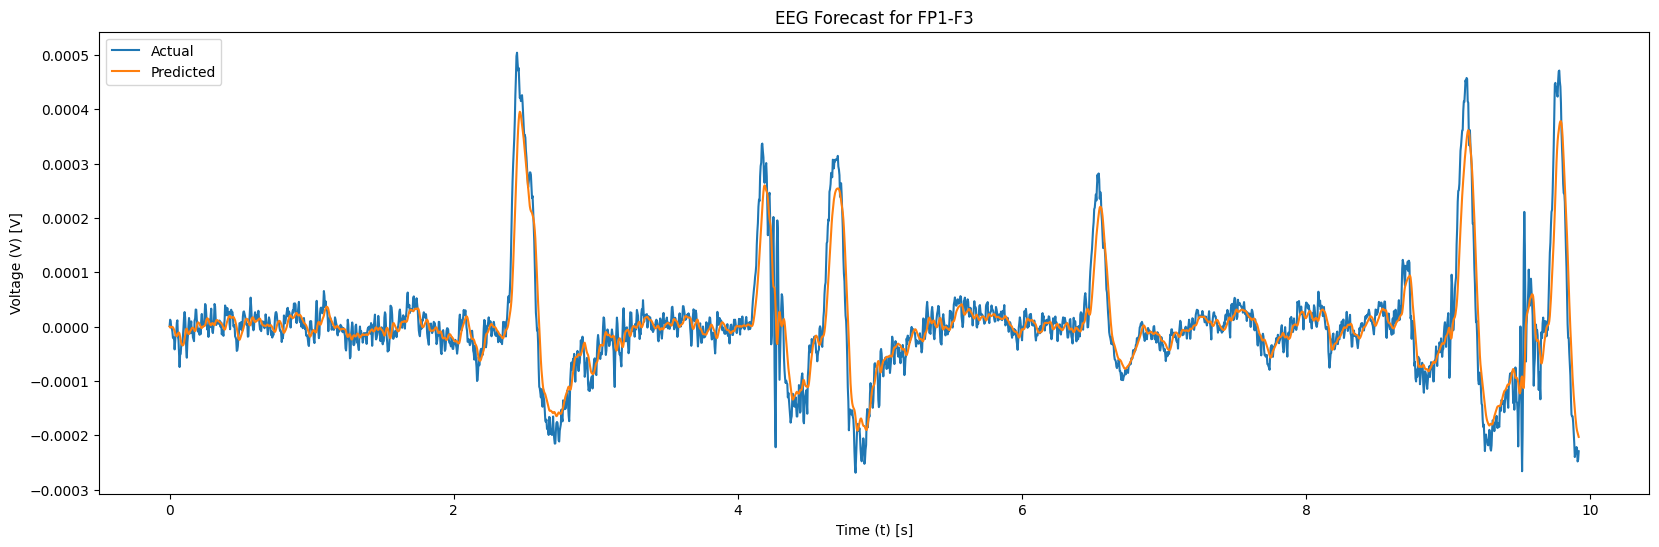

In [18]:
# plot results
for k in range(len(y_pred)):
    lstm_plot(y_test[k], y_pred[k], channels[k])